In [1]:
module willshaw76

using Plots, ImageFiltering, TestImages, ImageView; gr(); 

# Parameters
FRAME_RATE = 500
dt = 1

INIT_SYN_MEAN = 2.5                                 # S
INIT_SYN_SD = 0.14

POLARITY_MULT = 5
ACTIVITY_THRESH = 10                                # theta
MEM_TIME_CONST = 0.5                                # alpha
STATIONARITY_CONST = 0.005
SYN_MOD_THRESH = 2                                  # epsilon
HEBB_CONST = 0.0016                                 # h
INPUT_CLUSTER_SIZE = 2                              # c

beta = 0.05
gamma = 0.025
delta = -0.06
DIST_FILTER = [0 0 0 delta 0 0 0;
            0 0 delta gamma delta 0 0;
        0 delta gamma beta gamma delta 0;
            delta gamma beta 0 beta gamma delta;
            0 delta gamma beta gamma delta 0;
                0 0 delta gamma delta 0 0;
                    0 0 0 delta 0 0 0]


type ActivityModel
    ret_dim1::Int
    ret_dim2::Int
    tec_dim1::Int
    tec_dim2::Int
    tec_pms::Array{Int,1}
    pairs::Array{Int,2}
    num_pairs::Int
    syn_weights::Array{Float64,4}
    rf_centres::Array{Float64,3}
    iter_weights::Array{Float64,5}
    iter_rfs::Array{Float64,4}

    ## Constructor
    function ActivityModel(ni,nj,nk,nl,tec_pms)
        s = init_syns(ni, nj, nk, nl,tec_pms)
        (num_pairs,pairs) = gen_pairs(ni,nj)
        rf = zeros(nk, nl,2)
        iw = zeros(1,ni,nj,nk,nl)
        irf = zeros(1,nk,nl,2)

        new(ni, nj, nk, nl, tec_pms,pairs,num_pairs, s, rf,iw,irf)
    end

end


function run(model::ActivityModel,iterations)
    ni = model.ret_dim1
    nj = model.ret_dim2
    nk = model.tec_dim1
    nl = model.tec_dim2

    model.iter_weights = zeros(floor(Int64,iterations/FRAME_RATE)+1,
        ni,nj,nk,nl)
    model.iter_rfs = zeros(floor(Int64,iterations/FRAME_RATE)+1,
        nk,nl,2)

    tstart = time()

    for i in 1:iterations
        iteration(model)

        if i % FRAME_RATE == 0
            index = floor(Int64,i/FRAME_RATE)
            model.iter_weights[index,:,:,:,:] = model.syn_weights
            model.iter_rfs[index,:,:,:] = model.rf_centres
            report_progress(i,iterations,tstart)
        end

    end


end


function iteration(model::ActivityModel)
    pair = activate_ret(model.pairs,model.num_pairs)
    init_pot = activate_tec(model.syn_weights,pair)
    activity = update_potential(model.syn_weights,init_pot)
    model.syn_weights = update_syns(model.syn_weights,activity,pair,
        model.ret_dim1,model.ret_dim2,model.tec_dim1,model.tec_dim2)
    model.rf_centres = calc_rf_centres(model.syn_weights,
        model.ret_dim1,model.ret_dim2,model.tec_dim1,model.tec_dim2)
end


function init_syns(ni,nj,nk,nl,tec_pms)
    syn_weights = randn(ni,nj,nk,nl)*INIT_SYN_SD + INIT_SYN_MEAN

    imid1 =  fld(ni,2)
    imid2 = imid1 + 1

    jmid1 = fld(nj,2)
    jmid2 = jmid1 + 1

    kpm1 = tec_pms[1]
    kpm2 = tec_pms[2]
    lpm1 = tec_pms[3]
    lpm2 = tec_pms[4]

    syn_weights[imid1,jmid1,kpm1,lpm1] *= POLARITY_MULT
    syn_weights[imid1,jmid2,kpm1,lpm2] *= POLARITY_MULT
    syn_weights[imid2,jmid1,kpm2,lpm1] *= POLARITY_MULT
    syn_weights[imid2,jmid2,kpm2,lpm2] *= POLARITY_MULT

    syn_weights = norm_syns!(syn_weights,ni,nj,nk,nl)

    return syn_weights

end



function norm_syns!(syn_weights,ni,nj,nk,nl)
    reshaped_weights = reshape(syn_weights,(ni*nj,nk*nl))
    mu = mean(reshaped_weights,1)
    norm_weights = (reshaped_weights*INIT_SYN_MEAN)./mu
    syn_weights = reshape(norm_weights,(ni,nj,nk,nl))
    return syn_weights
end



function gen_pairs(ni,nj)
    num_pairs = 2*(ni-1)*(nj-1) + (ni-1) + (nj-1)
    pairs = zeros(Int,(num_pairs,4))
    count = 1 
    for i=1:ni, j=1:nj
        if i!=ni
            pairs[count,:] = [i,j,i+1,j]
            count += 1
        end

        if j!=nj
            pairs[count,:] = [i,j,i,j+1]
            count += 1
        end
    end

    return (num_pairs,pairs)

end


function activate_ret(pairs,num_pairs)
    pair  = pairs[rand(1:num_pairs),:]
    return pair
end


function activate_tec(syn_weights,pair)
    i1 = pair[1]
    j1 = pair[2]
    i2 = pair[3]
    j2 = pair[4]

    mem_pot = syn_weights[i1,j1,:,:] + syn_weights[i2,j2,:,:]
    return mem_pot
end


function update_potential(syn_weights,init_pot)
    cur_pot = copy(init_pot)
    mean_change = 1
    new_mean = mean(cur_pot)
    old_mean = 0
    while mean_change > (STATIONARITY_CONST*old_mean)
        old_mean = new_mean
        activity = thresh(copy(cur_pot))
        conv = tec_feedback(activity)
        pot_change = (init_pot + conv) - (MEM_TIME_CONST*cur_pot) 
        cur_pot += pot_change*dt
        new_mean = mean(cur_pot)
        mean_change = abs(new_mean-old_mean)
    end

    activity = thresh(cur_pot)
    return activity

end



function thresh(cur_pot)
    cur_pot[find(x -> x < ACTIVITY_THRESH, cur_pot)] = 0
    cur_pot[find(x -> x > ACTIVITY_THRESH, cur_pot)] -= ACTIVITY_THRESH
    return cur_pot
end



function tec_feedback(activity)
    filter = centered(DIST_FILTER)
    feedback = imfilter(activity,filter,Fill(0)) 
    return feedback
end


function update_syns(syn_weights,activity,pair,ni,nj,nk,nl)
    i1 = pair[1]
    j1 = pair[2]
    i2 = pair[3]
    j2 = pair[4]

    inds = find(x -> x > SYN_MOD_THRESH,activity)

    if length(inds)!=0
        syn_weights[i1,j1,inds] += HEBB_CONST*activity[inds]
        syn_weights[i2,j2,inds] += HEBB_CONST*activity[inds]
    end

    syn_weights = norm_syns!(syn_weights,ni,nj,nk,nl)

    return syn_weights

end


function calc_rf_centres(syn_weights,ni,nj,nk,nl)
    rec_field = zeros(nk,nl,2)
    rshpe_syns = reshape(syn_weights,(ni*nj,nk*nl))
    denom = sum(rshpe_syns,1)

    iinds = repeat([ i for i in 1:ni],inner=nj)
    inume = sum((rshpe_syns.*iinds),1)
    rshpe_irf = inume./denom
    irf = reshape(rshpe_irf,(nk,nl))

    jinds = repeat([ j for j in 1:nj],outer=ni)
    jnume = sum((rshpe_syns.*jinds),1)
    rshpe_jrf = jnume./denom
    jrf = reshape(rshpe_jrf,(nk,nl))

    rec_field[:,:,1] = irf
    rec_field[:,:,2] = jrf

    return rec_field

end


function report_progress(i,iterations,tstart)
    progress = ((i+1)*100)/iterations
    t = time()
    tpassed = (t-tstart)/60
    time2go = ((tpassed/progress)*100) - tpassed

    print("$(progress)% completed.  Time passed: $(@sprintf("%.3f",tpassed)).    Expected time left: $(@sprintf("%.3f",time2go))  \r")
    flush(STDOUT)

end
end  


willshaw76

In [92]:
using Plots, PyPlot, Interact, Reactive

function plot_iteration(model,iteration)
    rec_fields = model.iter_rfs[iteration,:,:,:]
    PyPlot.xlim(1,model.ret_dim1)
    PyPlot.ylim(1,model.ret_dim2)
    PyPlot.axes()[:set_aspect]("equal")
    
    for k in 1:model.tec_dim1
        i1 = []
        j1 = []

        for l in 1:model.tec_dim2
            append!(i1,rec_fields[k,l,1])
            append!(j1,rec_fields[k,l,2])
        end
        PyPlot.plot(i1,j1,c="k")
    end


    for l in 1:model.tec_dim2
        i2 = []
        j2 = []

        for k in 1:model.tec_dim1
            append!(i2,rec_fields[k,l,1])
            append!(j2,rec_fields[k,l,2])
        end
        PyPlot.plot(i2,j2,c="k")
    end
    PyPlot.show()
end



function plot_map(model::willshaw76.ActivityModel,FRAME_RATE)
    fig = figure()
    #plot_iteration(model,1)
    iterations = length(model.iter_rfs[:,1,1,1])*FRAME_RATE

    @manipulate for Iteration=1:iterations; withfig(fig) do  
        plot_iteration(model,floor(Int64,Iteration/FRAME_RATE)+1) 
    end
    end
end

plot_map (generic function with 1 method)

In [22]:
am = willshaw76.ActivityModel(5,5,5,5,[2,3,2,3]);

In [24]:
willshaw76.run(am,10000);

Interact.Options{:SelectionSlider,Int64}(95: "input-30" = 5250 Int64 ,"Iteration",5250,"5250",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(9775=>"9775",2843=>"2843",4495=>"4495",6928=>"6928",9905=>"9905",6380=>"6380",1316=>"1316",6265=>"6265",5459=>"5459",5842=>"5842"…)),Any[],Any[],true,"horizontal")

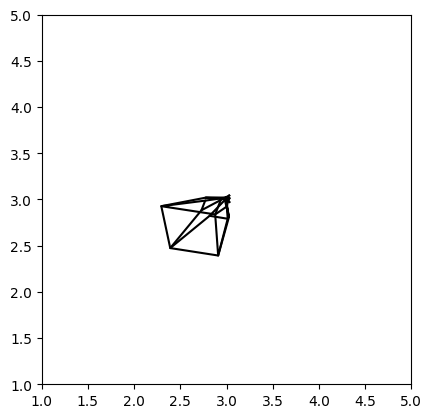

In [93]:
plot_map(am,500)

In [56]:
am.iter_rfs[1,:,:,:]

5×5×2 Array{Float64,3}:
[:, :, 1] =
 3.03178  2.99345  3.02465  2.99351  3.02014
 2.96561  2.83435  2.99913  3.01696  2.98138
 3.01145  2.82081  2.99997  2.99333  3.01811
 3.02267  3.01983  3.01725  3.00005  2.9921 
 3.03011  3.00302  3.02563  2.98459  3.03092

[:, :, 2] =
 3.04481  3.0103   2.99549  3.00684  3.00517
 3.05211  2.84372  2.80453  3.01635  2.998  
 2.98958  3.01965  2.98133  2.99652  3.00059
 3.01724  3.00923  3.01116  2.99607  2.99441
 2.97299  3.00536  3.01619  3.00799  3.01333

In [57]:
am.iter_rfs[15,:,:,:]

5×5×2 Array{Float64,3}:
[:, :, 1] =
 2.99858  2.6153   2.97813  3.00456  3.02014
 2.46941  2.2429   2.85301  3.03236  2.98138
 2.49252  2.17095  2.84002  3.02822  3.01811
 2.96012  2.51107  2.89906  3.00542  2.9921 
 3.03011  3.00302  3.02563  2.98459  3.03092

[:, :, 2] =
 3.0163   2.61575  2.58702  2.9062   3.00517
 2.71132  2.38025  2.33126  2.6443   2.998  
 2.98018  2.86285  2.79702  2.86404  3.00059
 3.02654  3.04573  3.02751  3.00064  2.99441
 2.97299  3.00536  3.01619  3.00799  3.01333